In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from backtesting import Strategy, Backtest
from tqdm import tqdm
tqdm.pandas()

Example of testing Michael Harris rejection pattern strategy on multiple assets

Original strategy on Code Trading YT channel: https://www.youtube.com/watch?v=tOH6Bd_jvfA

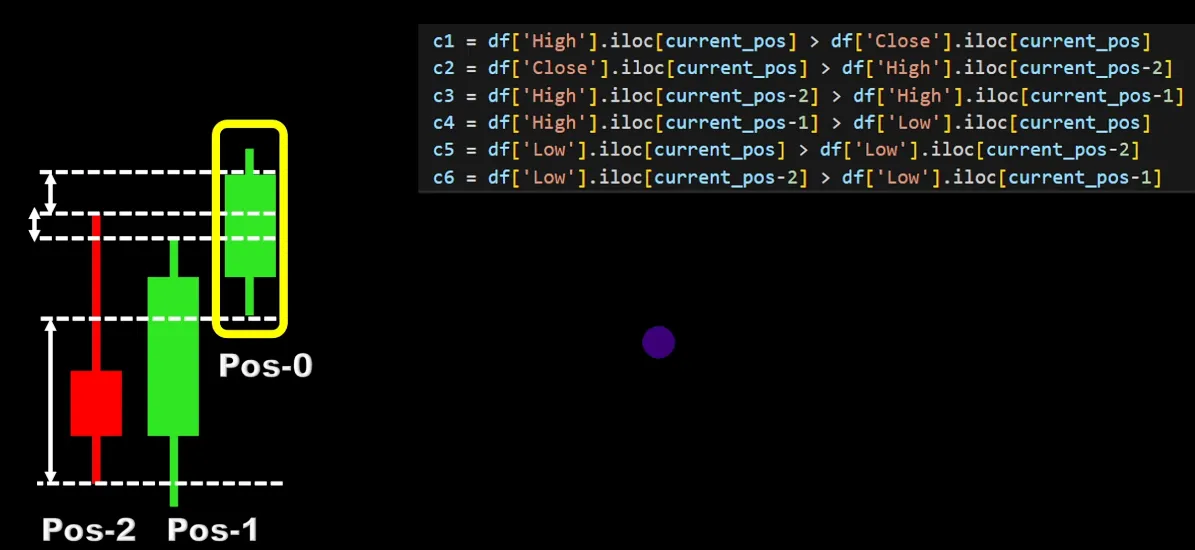

### Import yfinance data

In [9]:
def get_data(symbol: str):
    data = yf.download(tickers=symbol, period='5y', interval='1d')
    data.columns = data.columns.droplevel(-1)
    data.reset_index(inplace=True)
    return data

dataframes = []
tickers = ['QQQ', 'SPY']
for ticker in tickers:
    dataframes.append(get_data(ticker))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Signal function

In [10]:
def total_signal(df, current_candle):
    current_pos = df.index.get_loc(current_candle)
    
    # Buy condition (go long)
    c1 = df['High'].iloc[current_pos] > df['Close'].iloc[current_pos]
    c2 = df['Close'].iloc[current_pos] > df['High'].iloc[current_pos-2]
    c3 = df['High'].iloc[current_pos-2] > df['High'].iloc[current_pos-1]
    c4 = df['High'].iloc[current_pos-1] > df['Low'].iloc[current_pos]
    c5 = df['Low'].iloc[current_pos] > df['Low'].iloc[current_pos-2]
    c6 = df['Low'].iloc[current_pos-2] > df['Low'].iloc[current_pos-1]

    if c1 and c2 and c3 and c4 and c5 and c6:
        return 2

    return 0

def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name), axis=1)
    return df

### Visualization functions

#### Add signal points positions

In [11]:
def add_pointpos_column(df, signal_column):
    def pointpos(row):
        if row[signal_column] == 2:
            return row['Low'] - 1e-4
        elif row[signal_column] == 1:
            return row['High'] + 1e-4
        else:
            return np.nan

    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    return df

#### Plot candlestick chart

In [12]:
def plot_candlestick_with_signals(df, start_index, num_rows):
    df_subset = df[start_index:start_index + num_rows]
    
    fig = make_subplots(rows=1, cols=1)
    
    fig.add_trace(go.Candlestick(x=df_subset.index,
                                 open=df_subset['Open'],
                                 high=df_subset['High'],
                                 low=df_subset['Low'],
                                 close=df_subset['Close'],
                                 name='Candlesticks'),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset['pointpos'], mode="markers",
                             marker=dict(size=10, color="MediumPurple", symbol='circle'),
                             name="Entry Points"),
                  row=1, col=1)
    
    fig.update_layout(
        width=1200, 
        height=800, 
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        xaxis=dict(showgrid=True, zeroline=False, gridcolor='black'),
        yaxis=dict(showgrid=True, zeroline=False, gridcolor='black'),
        showlegend=True,
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            ),
            bgcolor="white",
            bordercolor="gray",
            borderwidth=2
        )
    )
    fig.show()

### Enumerate tickers list for data

In [ ]:
for i, df in enumerate(dataframes):
    print("working on dataframe ", tickers[i], "...")
    df = add_total_signal(df)
    df = add_pointpos_column(df, "TotalSignal")
    dataframes[i] = df
    

working on dataframe  QQQ ...


100%|██████████| 1258/1258 [00:00<00:00, 5474.33it/s]


working on dataframe  SPY ...


100%|██████████| 1258/1258 [00:00<00:00, 7701.34it/s]


In [16]:
#count the total numb of signals in all dataframes
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)


TotalSignal
0    2464
2      52
Name: count, dtype: int64

In [17]:
#QQQ - dataframes[0]
plot_candlestick_with_signals(dataframes[0], start_index=300, num_rows=355)

### Strategy backtest & optimize

In [18]:
def SIGNAL():
    ''' Returns TotalSignal column (our entry signals) from the df
    '''
    return df.TotalSignal

class MyStrat(Strategy):
    ''' Define sl, tp, trade size, long positions based on signals
        Optimize sl and tp % parameters with optimze function
    '''
    mysize = 0.1  # Trade size
    slperc = 0.08
    tpperc = 0.08

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL) 

    def next(self):
        super().next()
         
        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL and TP
            current_close = self.data.Close[-1]
            sl = current_close - self.slperc * current_close  # SL at slperc% below the close price
            tp = current_close + self.tpperc * current_close  # TP at tpperc% above the close price
            self.buy(size=self.mysize, sl=sl, tp=tp)


In [ ]:
results = []
heatmaps = []

#optimize the stategy for range of sl/tp %
#including small commision to account for the spread
#no risk of overfitting as we are not optimizing any indicator

for df in dataframes:
    bt = Backtest(df, MyStrat, cash=10000, margin=1/5, commission=0.0002)
    stats, heatmap = bt.optimize(slperc=[i/100 for i in range(2, 10)],
                                 tpperc=[i/100 for i in range(2, 10)],
                    maximize='Return [%]', max_tries=3000,
                        random_state=0,
                        return_heatmap=True)
    results.append(stats)
    heatmaps.append(heatmap)

In [20]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)
win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
max_trade_duration = max([r["Max. Trade Duration"] for r in results])
avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
print(f"Maximum Trade Duration: {max_trade_duration} days")
print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 46.10%
Number of Trades: 33.0
Maximum Drawdown: -12.70%
Average Drawdown: -1.07%
Win Rate: 66.07%
Best Trade: 11.75%
Worst Trade: -7.81%
Average Trade: 2.90%
Maximum Trade Duration: 137.0 days
Average Trade Duration: 35.29 days


#### Equity curves

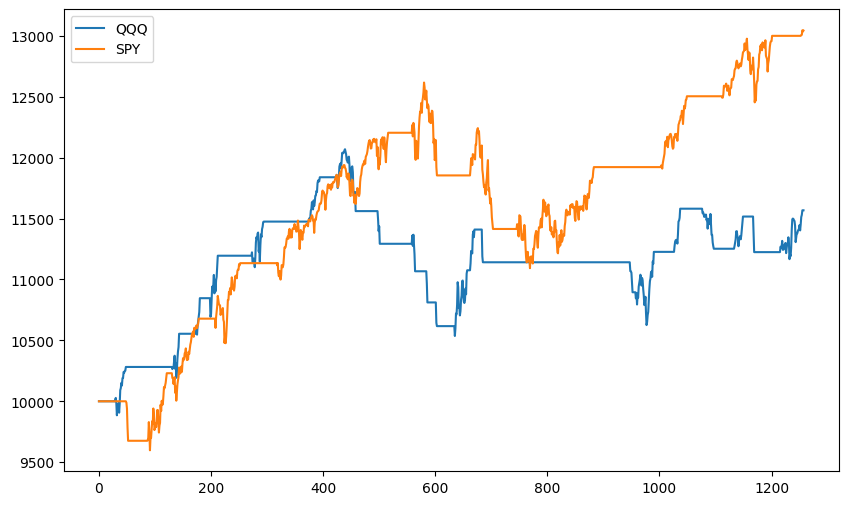

In [21]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('white')
plt.legend(tickers)

In [22]:
[r["Return [%]"] for r in results]

[15.67465650427248, 30.424983183166514]

#### Stat & Heatmap SL/TP

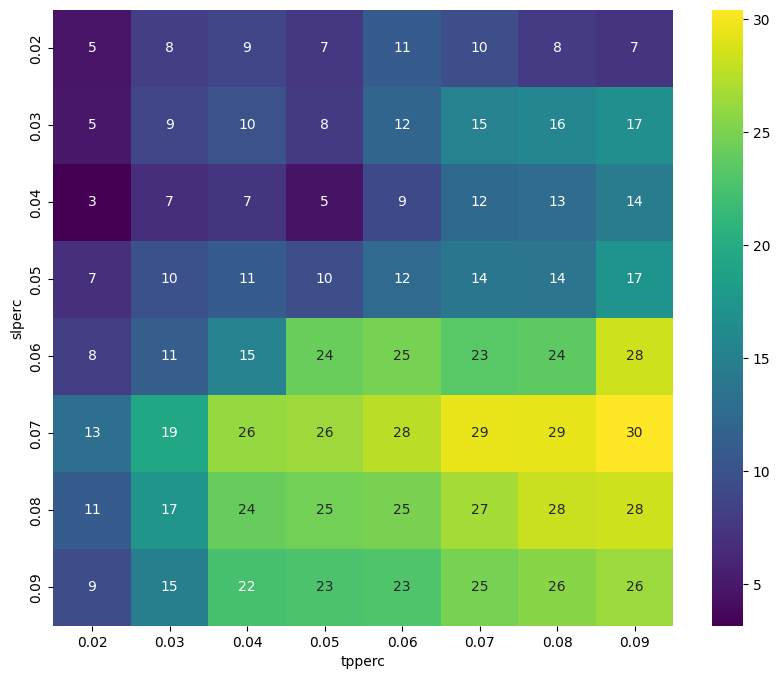

In [23]:
# Convert multiindex series to dataframe
heatmap_df = heatmaps[1].unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [ ]:
results[1] #SPY stats

Start                                     0.0
End                                    1257.0
Duration                               1257.0
Exposure Time [%]                   55.246423
Equity Final [$]                 13042.498318
Equity Peak [$]                  13044.698025
Return [%]                          30.424983
Buy & Hold Return [%]               93.644064
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -12.07409
Avg. Drawdown [%]                   -0.989651
Max. Drawdown Duration                  549.0
Avg. Drawdown Duration              17.388889
# Trades                                 12.0
Win Rate [%]                             75.0
Best Trade [%]                      11.747648
Worst Trade [%]                     -7.809134
Avg. Trade [%]                    